In [6]:
cifar_dir = 'cifar-10-batches-py/'

In [7]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        cifar_dict = pickle.load(f,encoding='bytes')
     
    return cifar_dict

In [8]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [9]:
all_data = [0,1,2,3,4,5,6]

In [10]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(cifar_dir+direc)

In [11]:
batches_meta = all_data[0]
data_batch_1 = all_data[1]
data_batch_2 = all_data[2]
data_batch_3 = all_data[3]
data_batch_4 = all_data[4]
data_batch_5 = all_data[5]
test_batch = all_data[6]

In [12]:
data_batch_1

{b'batch_label': b'training batch 1 of 5',
 b'data': array([[ 59,  43,  50, ..., 140,  84,  72],
        [154, 126, 105, ..., 139, 142, 144],
        [255, 253, 253, ...,  83,  83,  84],
        ...,
        [ 71,  60,  74, ...,  68,  69,  68],
        [250, 254, 211, ..., 215, 255, 254],
        [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8),
 b'filenames': [b'leptodactylus_pentadactylus_s_000004.png',
  b'camion_s_000148.png',
  b'tipper_truck_s_001250.png',
  b'american_elk_s_001521.png',
  b'station_wagon_s_000293.png',
  b'coupe_s_001735.png',
  b'cassowary_s_001300.png',
  b'cow_pony_s_001168.png',
  b'sea_boat_s_001584.png',
  b'tabby_s_001355.png',
  b'muntjac_s_001000.png',
  b'arabian_s_001354.png',
  b'quarter_horse_s_000672.png',
  b'passerine_s_000343.png',
  b'camion_s_001895.png',
  b'trailer_truck_s_000335.png',
  b'dumper_s_000821.png',
  b'alley_cat_s_000200.png',
  b'accentor_s_000677.png',
  b'frog_s_001671.png',
  b'capreolus_capreolus_s_000051.png',
  b'tomcat

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [14]:
X = data_batch_1[b'data']
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")
saap = data_batch_1[b'labels']
saap[1]

9

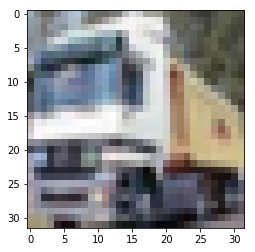

In [15]:
plt.imshow(X[1])

In [16]:
class Cifar_model():
    def __init__(self):
        self.i = 0
        self.training_images = None
        self.training_labels = None
        self.data_batches = [data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5]
        self.test_images = None
        self.test_labels = None
        self.test_batch = [test_batch]
       
    
    def set_up_images(self):
        print("Setting up training images and labels")
        self.training_images = np.vstack(d[b'data'] for d in self.data_batches)
        self.training_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.data_batches),10)
        training_len = len(self.training_images)
        self.training_images = self.training_images.reshape(training_len,3,32,32).transpose(0,2,3,1)/255
        
        
        print("Setting up testing images and labels")
        self.test_images = np.vstack(d[b'data'] for d in self.test_batch)
        self.test_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.test_batch),10)
        testing_len = len(self.test_images)
        self.test_images = self.test_images.reshape(testing_len,3,32,32).transpose(0,2,3,1)/255
        
       
    def next_batch(self,batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y

In [17]:
def one_hot_encode(vec,vals):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [18]:
ch = Cifar_model()
ch.set_up_images()

Setting up training images and labels
Setting up testing images and labels


In [19]:
import tensorflow as tf

In [20]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
hold_prob = tf.placeholder(tf.float32)

In [21]:
def init_weights(shape):
    init_rand_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_rand_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input_x,shape):
    w = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, w) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    w = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, w) + b

In [22]:
conv_1 = conv_layer(x,shape=[3,3,3,16])
conv_1_pool = max_pool_2by2(conv_1)

In [23]:
conv_2 = conv_layer(conv_1_pool,shape=[3,3,16,32])
conv_2_pool = max_pool_2by2(conv_2)

In [24]:
conv_3 = conv_layer(conv_2_pool,shape=[2,2,32,64])
conv_3_pool = max_pool_2by2(conv_3)
conv_3_drop=tf.nn.dropout(conv_3_pool,keep_prob=hold_prob)

conv_3_drop.get_shape().as_list()

[None, 4, 4, 64]

In [25]:
4*4*64

1024

In [26]:
conv_3_flat = tf.reshape(conv_3_drop,[-1,4*4*64])#tf.reshape(conv_3_pool,[-1,1024])


In [27]:
affine_layer_1 = tf.nn.relu(normal_full_layer(conv_3_flat,1024))
affine_layer_1.get_shape().as_list()

[None, 1024]

In [28]:
affine_layer_2 = tf.nn.relu(normal_full_layer(affine_layer_1,128))
affine_layer_2.get_shape().as_list()

[None, 128]

In [29]:
drop_out = tf.nn.dropout(affine_layer_2,keep_prob=hold_prob)

In [30]:
y_pred = normal_full_layer(drop_out,10)

In [31]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [32]:
optim = tf.train.AdamOptimizer(learning_rate=0.001)

In [33]:
train = optim.minimize(cross_entropy)

In [34]:
init = tf.global_variables_initializer()

In [35]:
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    n_epochs = 2000
    for i in range(n_epochs):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.25})
       
        if i%100 == 0:
            print("Currently on step : {}".format(i))
            print("Accuracy is :")
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            #matches = [True,False,True,True,.......]
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print("\n")
       
    saver.save(sess,"./cifar_10_train_model")

Currently on step : 0
Accuracy is :


In [2]:
import tensorflow as tf
import cv2
test_path = 'test1.jpeg'
test_image1 = cv2.imread(test_path)
test_image1=cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)

In [4]:

with tf.Session() as sess:
    sess = tf.train.Saver().restore("./cifar_10_train_model")
    pred = sess.run(y_pred,feed_dict={x:test_image1,hold_prob:1.0})
   
    

ValueError: No variables to save